In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [2]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+425.ga8f1b2dda.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.32 GB available memory.


In [9]:
# load initial equilibrium
from desc.io import load
from desc.compat import rotate_zeta

try:
    eq = load("Poincare/Optimization/poincare_precise_QH_initial_eq.h5")
    eq.xsection = eq.get_surface_at(zeta=0)
    eq.surface = eq.get_surface_at(rho=1)
except FileNotFoundError:
    eq = load("../desc/examples/precise_QH_output.h5")[0]
    constraints = get_fixed_xsection_constraints(eq=eq)
    objective = ObjectiveFunction(ForceBalance(eq))

    # before optimization make sure that the initial equilibrium
    # is in force balance in terms of poincare constraints
    eq.solve(
        verbose=0,
        objective=objective,
        constraints=constraints,
        maxiter=100,
        ftol=1e-3,
    )
    eq.xsection = eq.get_surface_at(zeta=0)
    eq.surface = eq.get_surface_at(rho=1)
    eq.save("poincare_precise_QH_initial_eq.h5")

eq = rotate_zeta(eq, angle=np.pi / eq.NFP)
eq.surface = eq.get_surface_at(rho=1.0)
eq.xsection = eq.get_surface_at(zeta=0)
eq.axis = eq.get_axis()

eqfam = EquilibriaFamily(eq)
eq00 = get("precise_QH")
V = eq.compute("V")["V"]
Vorg = eq00.compute("V")["V"]

# grid for computing quasisymmetry objective
grid = LinearGrid(M=eq.M, N=eq.N, NFP=eq.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True)

# weights for objectives
w_qs = 1
w_ar = 50
w_vol = 10

file_identifier = f"poincare_optimize_QH_wqs{w_qs}_war{w_ar}_wvol{w_vol}"

In [11]:
def run_step(n, eqfam, ftol=1e-2, **kwargs):
    objective = ObjectiveFunction(
        (
            QuasisymmetryTwoTerm(
                eq=eqfam[-1],
                helicity=(1, eqfam[-1].NFP),
                grid=grid,
                normalize=False,
                weight=w_qs,
            ),
            AspectRatio(eq=eqfam[-1], target=8, weight=w_ar, normalize=False),
            Volume(
                eq=eqfam[-1], target=Vorg, weight=w_vol, normalize=False
            ),  # giving Vorg is kind of cheating
        ),
    )
    # modes to fix
    bc_surf = eqfam[-1].xsection
    R_modes = bc_surf.R_basis.modes[np.max(np.abs(bc_surf.R_basis.modes), 1) > n, :]
    Z_modes = bc_surf.Z_basis.modes[np.max(np.abs(bc_surf.Z_basis.modes), 1) > n, :]
    constraints = (
        ForceBalance(eq=eqfam[-1]),
        FixSectionR(eq=eqfam[-1], modes=R_modes),
        FixSectionZ(eq=eqfam[-1], modes=Z_modes),
        FixPressure(eq=eqfam[-1]),
        FixCurrent(eq=eqfam[-1]),
        FixPsi(eq=eqfam[-1]),
    )

    optimizer = Optimizer("proximal-lsq-exact")
    eq_new, _ = eqfam[-1].optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=250,
        verbose=3,
        ftol=ftol,
        copy=True,
        options={
            "perturb_options": {"verbose": 0},
            "solve_options": {"verbose": 0, "ftol": 1e-3, "maxiter": 250},
            **kwargs,
        },
    )
    # to make sure the surfaces are updated properly
    eq_new.xsection = eq_new.get_surface_at(zeta=0)
    eq_new.surface = eq_new.get_surface_at(rho=1)
    eqfam.append(eq_new)
    return eqfam

In [17]:
Vorg

Array(0.3019, dtype=float64)

Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 68.6 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 28.6 ms
Building objective: volume
Precomputing transforms
Timer: Precomputing transforms = 29.2 ms
Timer: Objective build = 143 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 64.6 ms
Timer: Objective build = 75.5 ms
Timer: Objective build = 1.23 ms
Timer: Eq Update LinearConstraintProjection build = 179 ms
Timer: Proximal projection build = 49.1 sec
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 149 ms
Timer: LinearConstraintProjection build = 181 ms
Number of parameters: 45
Number of objectives: 461
Timer: Initializing the optimization = 49.5 sec

Starting optimization
Using method: proximal-lsq-exact
So

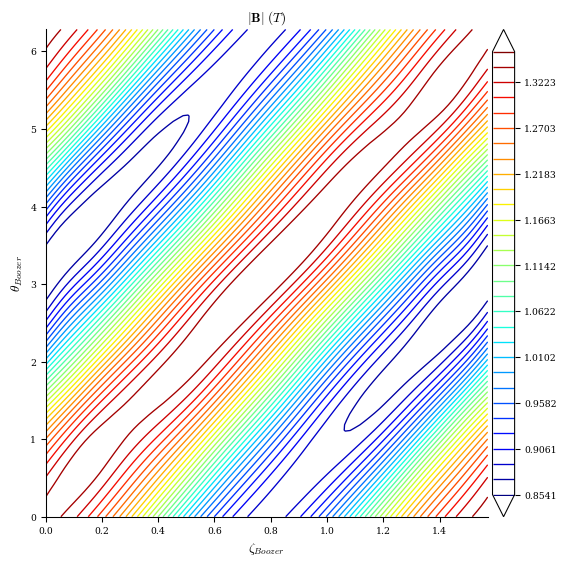

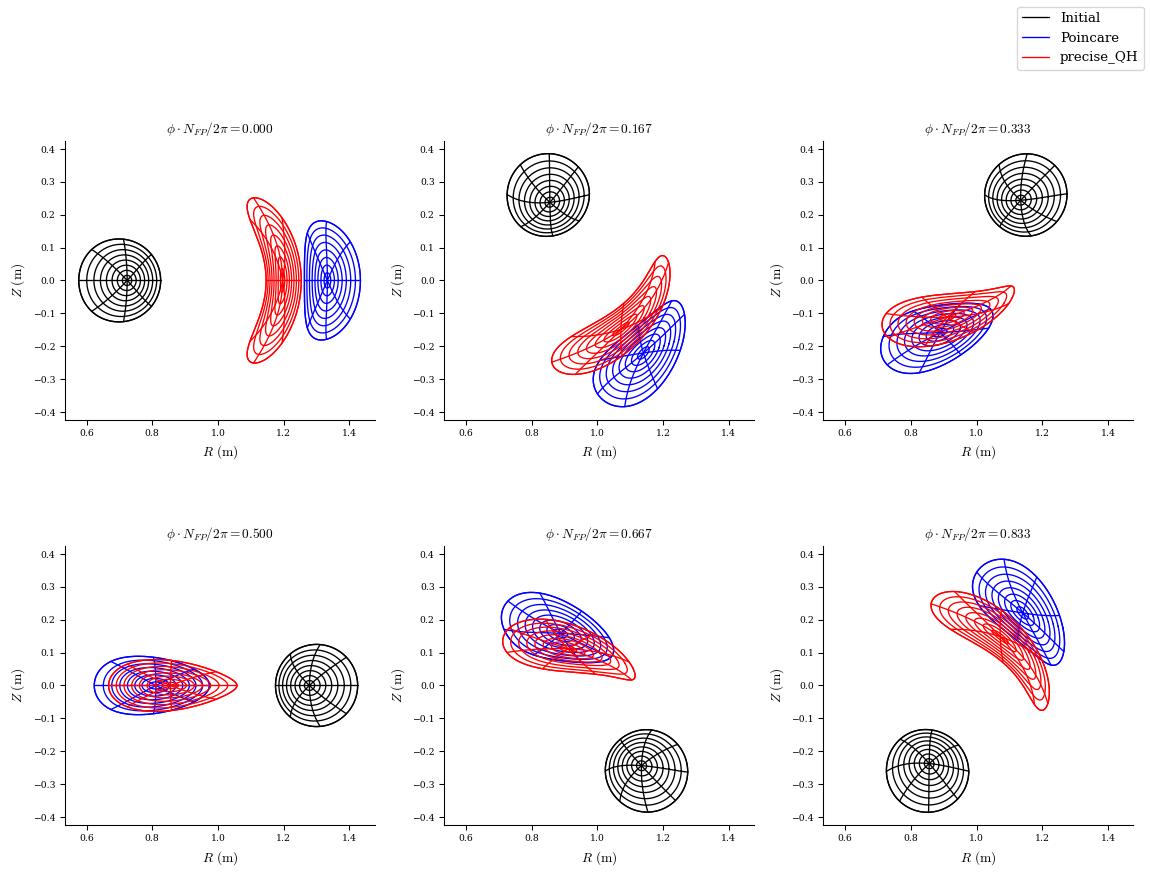

In [12]:
eqfam = run_step(8, eqfam, ftol=1e-3)
plot_boozer_surface(eqfam[-1])


eq_rotated = eqfam[-1].copy()
eq_rotated = rotate_zeta(eq_rotated, np.pi / eq.NFP)
plot_comparison(
    eqs=[eqfam[0], eq_rotated, eq00],
    labels=["Initial", "Poincare", "precise_QH"],
    color=["black", "blue", "red"],
);

(<Figure size 1152.32x960.27 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>], dtype=object))

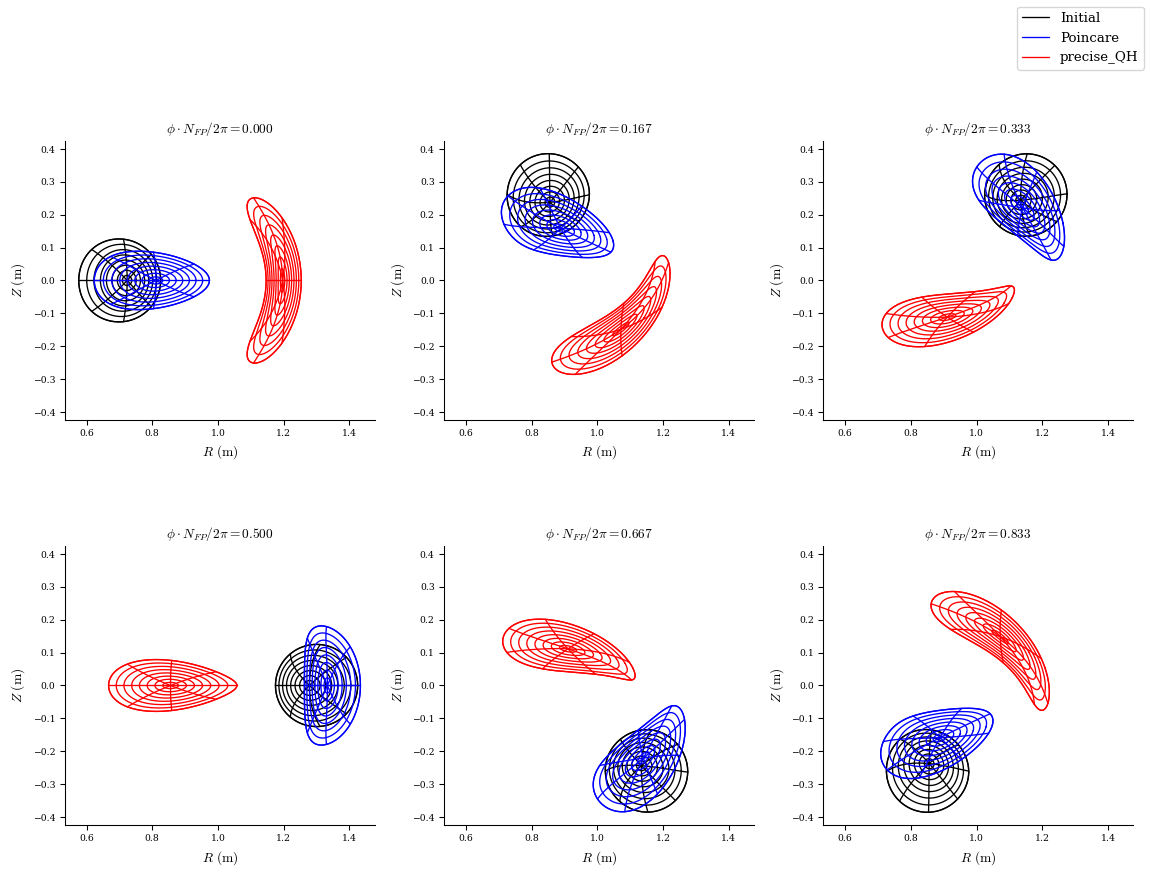

In [13]:
plot_comparison(
    eqs=[eqfam[0], eqfam[-1], eq00],
    labels=["Initial", "Poincare", "precise_QH"],
    color=["black", "blue", "red"],
)

(<Figure size 576.162x576.162 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

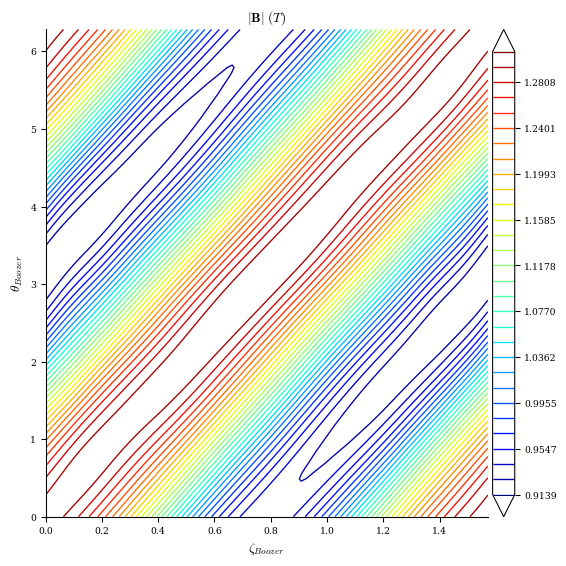

In [16]:
plot_boozer_surface(eqfam[-1], rho=0.8)

In [21]:
eqa0 = load("../desc/examples/precise_QA_output.h5")[0]
eqa1 = get("precise_QA")
eqa0_rotated = eqa0.copy()
eqa0_rotated = rotate_zeta(eqa0_rotated, np.pi / eqa0.NFP)

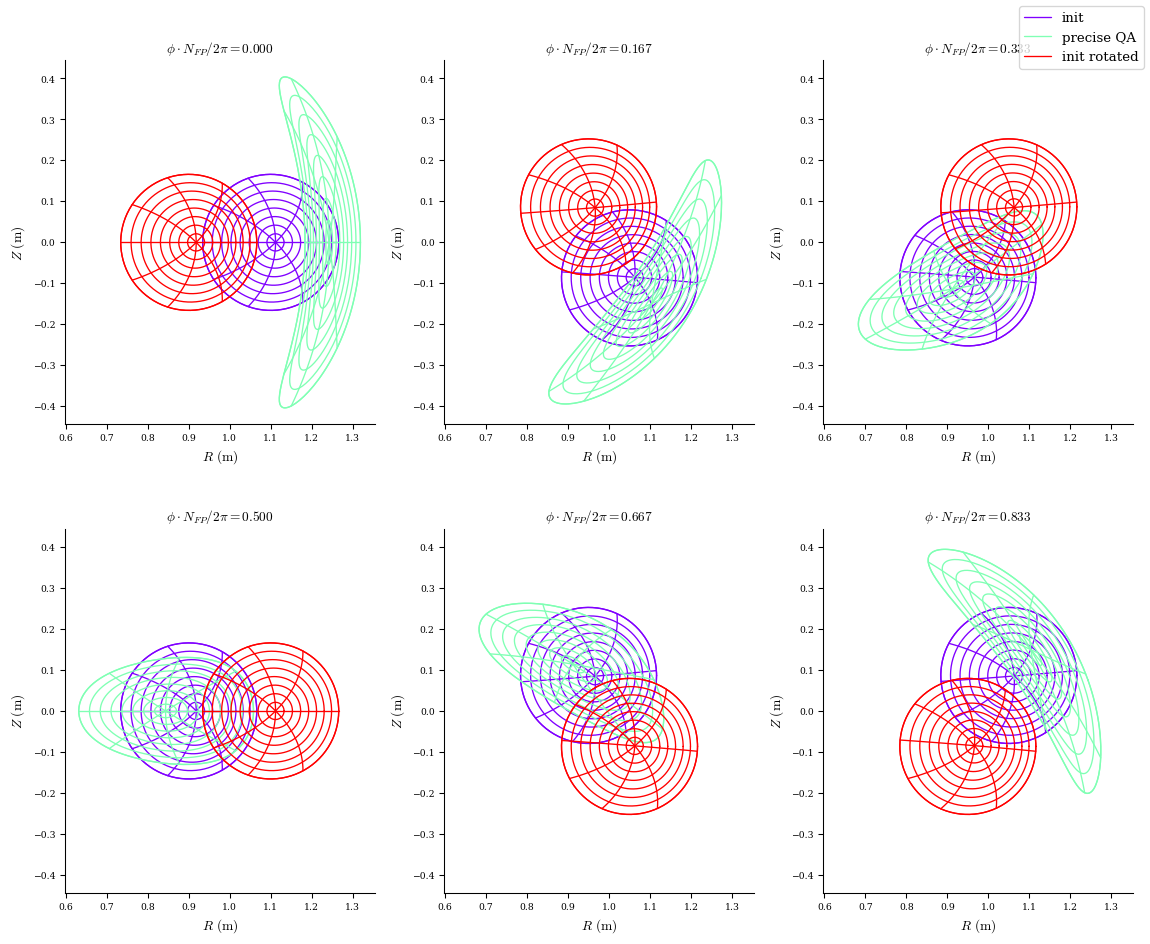

In [23]:
plot_comparison([eqa0, eqa1, eqa0_rotated], labels=["init", "precise QA", "init rotated"]);

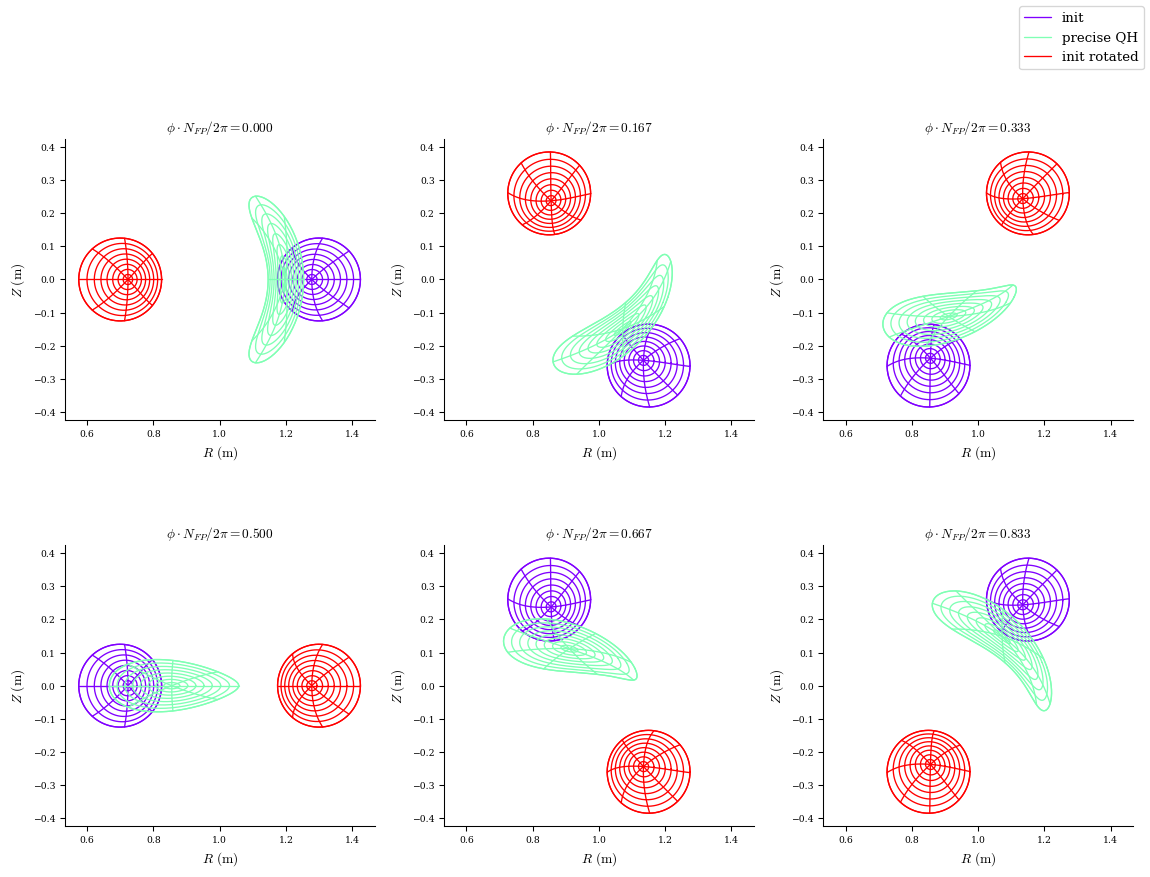

In [25]:
eqa0 = load("../desc/examples/precise_QH_output.h5")[0]
eqa1 = get("precise_QH")
eqa0_rotated = eqa0.copy()
eqa0_rotated = rotate_zeta(eqa0_rotated, np.pi / eqa0.NFP)
plot_comparison(
    [eqa0, eqa1, eqa0_rotated], labels=["init", "precise QH", "init rotated"]
);